# Entanglement in Action

In the following, we will look at some examples of entanglement:

* Teleportation Protocol
* Superdense Coding
* CHSH Game

First, let's import all relevant libraries:

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

## Quantum Teleportation

Now, we move on to the first example where we implement a Quantum teleportation protocol. Under Quantum teleportation protocol, we understand a protocol where a sender (Alice) transmits a qubit to a receiver (Bob) by making use of a shared entangled quantum state along with two bits of classical communication.

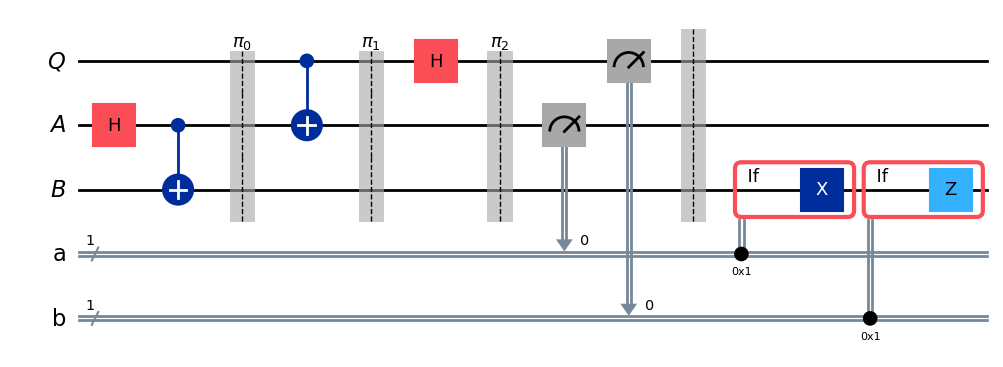

In [6]:
# Qubit that will be transmitted
qubit = QuantumRegister(1, "Q")

# Alice
ebit0 = QuantumRegister(1, "A")
# Bob
ebit1 = QuantumRegister(1, "B")

#Two bits of classical communication
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

# Set up the protocol
protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)
 
# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
#The barrier will make the output visually more structured
protocol.barrier(label='$\pi_0$')
 
# Alice's operations
protocol.cx(qubit, ebit0)
protocol.barrier(label='$\pi_1$')
protocol.h(qubit)
protocol.barrier(label='$\pi_2$')
 
# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()
 
# Bob uses the classical bits to conditionally apply gates
# this is done with the if_test function
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)
 
display(protocol.draw(output="mpl"))

Let's first describe the quantum circuit above, followed by verifying that the implemented protocol works.

### Description

The first step, the preparation of the shared state between A(lice) and B(ob) is strictly speaking not part of the protocol. By applying a Hadamard gate, followed by a CNOT gate, we create the $|\phi^+\rangle$ state. After that the protocol starts. Before applying any gates, the general state, we have is
\begin{equation}
|\pi_0\rangle = |\phi^+\rangle \otimes (\alpha|0\rangle+\beta|1\rangle) = \frac{\alpha|000\rangle + \alpha|110\rangle +\beta |001\rangle + \beta |111\rangle}{\sqrt{2}}
\end{equation}
if we assume that Q is in the state $\alpha|0\rangle+\beta|1\rangle$. The order of the qubits will be (B,A,Q).

1. CNOT gate on pair (A,Q), with Q being the control, and A being the target, which transforms the state into
   \begin{equation}
   |\pi_1\rangle=\frac{\alpha|000\rangle+\alpha|110\rangle+\beta|011\rangle+\beta|101\rangle}{\sqrt{2}}
   \end{equation}
   followed by a Hadamard gate on Q, after which we have
   \begin{equation}
   |\pi_2\rangle=\frac{\alpha|000\rangle+\alpha|001\rangle+\alpha|110\rangle+\alpha|111\rangle+\beta|010\rangle-\beta|011\rangle+\beta|100\rangle-\beta|101\rangle}{2}
   \end{equation}
   which can be written as
   \begin{align}
   |\pi_2\rangle = &\frac12 (\alpha|0\rangle + \beta |1\rangle)|00\rangle\\
                   +&\frac12 (\alpha|0\rangle - \beta |1\rangle)|01\rangle\\
                   +&\frac12 (\alpha|1\rangle + \beta |0\rangle)|10\rangle\\
                   +&\frac12 (\alpha|1\rangle - \beta |0\rangle)|11\rangle\\ 
   \end{align}
   Here, we can see what gates have to be applied to transform B into $(\alpha|0\rangle + \beta |1\rangle)$ based on the qubits A, and Q in (B,A,Q).
4. Alice measures both A, and Q, and transmits the classical outcomes to Bob (A $\to a$, and Q $\to b$).
5. Depending on the outcome, Bob is applying a gate:
   - if a=1, apply X gate to B
   - if b=1, apply Z gate to B

### Test

To test the implemented protocol, we apply a radomly generated single-qubit gate $U$ to the initialized $|0\rangle$ state of Q. By applying the inverse $U^{-1}$ to the final B state which should then return $|0\rangle$.

A random gate can be defined as

In [7]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)
 
display(array_to_latex(random_gate.to_matrix()))

<IPython.core.display.Latex object>

The test circuit is structured as follows. First, the random gate is applied to Q, then we run the teleportation protocol, and finally, we apply the inverse of the random gate to B and measure the outcome (which should be 0 with certainty).

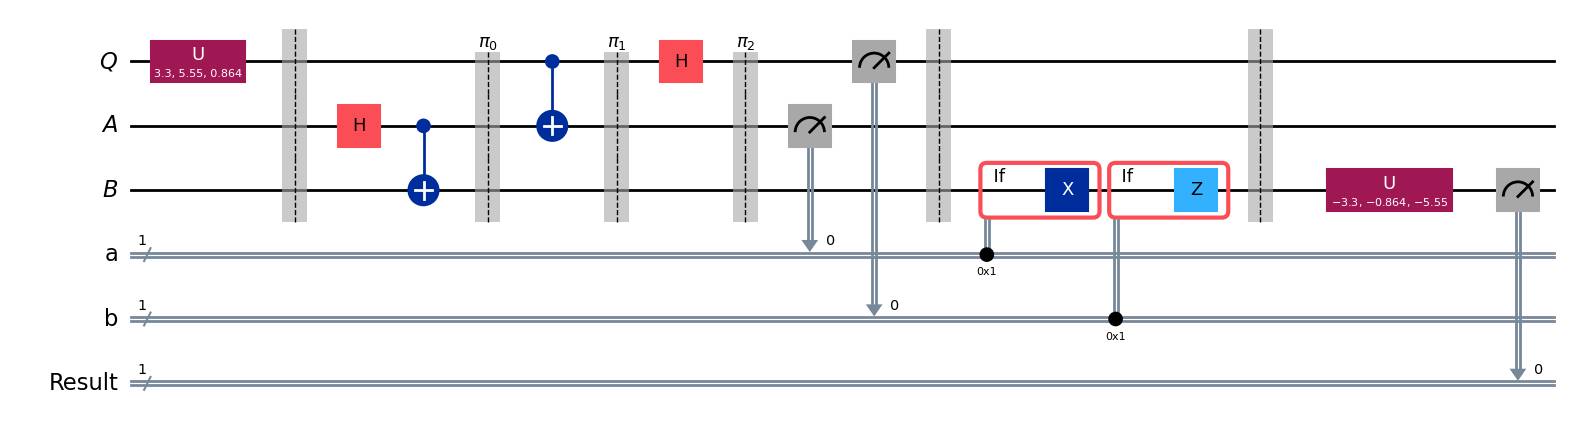

In [8]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.
 
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)
 
# Start with the randomly selected gate on Q
 
test.append(random_gate, qubit)
test.barrier()
 
# Append the entire teleportation protocol from above.
 
test = test.compose(protocol)
test.barrier()
 
# Finally, apply the inverse of the random unitary to B and measure.
 
test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)
 
display(test.draw(output="mpl"))

## Superdense Coding